# Supervised Learning

### Goals of the exercise
This exercise has three parts. The goal of the first part is to get more experience with supervised classification. We will use simple synthetic datasets and focus on the learning algorithms. 

The goal of the second part is to consider the implementaion of the  Multi-layer feed forward neural network, often called Multi-layer perceptron (MLP).

The third part, which is the smallest one, is dedicated to evaluation.

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random
from sys import maxsize

# Part 1: Comparing classifiers
## Datasets
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs regarding how the data are generated.)

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.

In [2]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [3]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [4]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [5]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

Plot the two training sets.

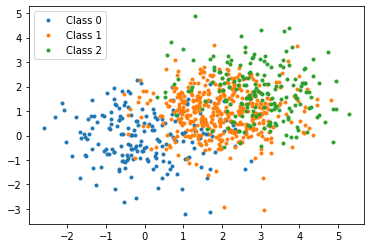

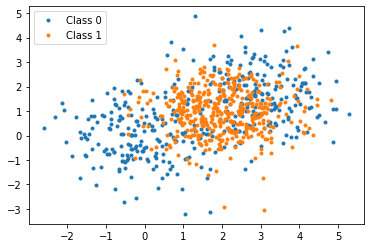

In [6]:
def show(X, y, marker='.'):
    # Ensures we get two plots by making each its own figure
    plt.figure()
    labels = set(y)
    for lab in labels:
        plt.plot(X[y == lab][:, 1], X[y == lab][:, 0], marker, label="Class {}".format(lab))
    plt.legend()

# Running the show-function
show(X_train, t_train)
show(X_train, t2_train)

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You provide the number of epochs with a parameter to the fit-method. However, you do not know what a reasonable number of epochs is. Add one more argument to the fit-method *diff* (with defualt value e.g. 0.001). The training should stop when the update is less than *diff*. The *diff* will save training time, but it may also be wise to not set it too small -- and not run training for too long -- to avoid overfitting.

Train the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*. Choose what you think is optimal *diff*. Report accuracy and save it for later.

In [7]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test)/len(pred)

In [8]:
class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        self.weights = weights = np.zeros(m+1)
        
        nRuns = 0
        """
        Update the MSE before updating the weights. 
        If the difference in MSE between the current solution and the next,
        we stop the training as we assume we've reached a minimum (local or global)
        """
        trueDiff = maxsize
        while trueDiff > diff:
            currentMSE = mse(t_train, X_train @ weights)
            weights -= eta / k *  X_train.T @ ((X_train @ weights) - t_train)
            nextMSE = mse(t_train, X_train @ weights)
            trueDiff = currentMSE - nextMSE
            nRuns += 1
            # Update a run counter to keep track of number of runs
        return nRuns
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.weights
        return score>threshold

In [9]:
def mse(y, y_pred):
    sum_errors = 0.
    for i in range(0,len(y)):
        sum_errors += (y[i] - y_pred[i])**2
    mean_squared_error = sum_errors/len(y)
    return mean_squared_error

def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1) 

In [10]:

"""
def runLin(linClass, X_train, t_train, X_val, t_val, eta = 0.1, epochs=10, diff=0.001): 
    runs = linClass.fit(X_train, t_train, eta, epochs, diff)
    accuracy = linClass.accuracy(X_train, t_train)
    print(f"Runs with diff: {diff}: {runs}\n Achieved accuracy: {accuracy}\n")
    

"""
    
def runLin(linClass, X_train, t_train, X_val, t_val, eta = 0.1, epochs=10, diff=0.001): 
    runs = linClass.fit(X_train, t_train, eta, epochs, diff)
    accuracy = [diff, linClass.accuracy(X_val, t_val)]
    print(f"Runs with diff: {accuracy[0]}: {runs}\nAchieved accuracy: {accuracy[1]}\n")
    return accuracy

In [11]:
linReg = NumpyLinRegClass()
diff = 0.1

resultsLin = []
for i in range(10):
    resultsLin.append(runLin(linReg, X_train, t2_train, X_val, t2_val, diff=diff)) 
    # Save nested list of diffs and accuracies
    
    diff = diff/10

bestAccLin = max(resultsLin, key=lambda x: x[1])

print(f"Best achieved accuracy: {bestAccLin[1]} with diff = {bestAccLin[0]}")
    


Runs with diff: 0.1: 2
Achieved accuracy: 0.47

Runs with diff: 0.01: 3
Achieved accuracy: 0.4775

Runs with diff: 0.001: 19
Achieved accuracy: 0.51

Runs with diff: 0.0001: 51
Achieved accuracy: 0.56

Runs with diff: 1e-05: 83
Achieved accuracy: 0.58

Runs with diff: 1.0000000000000002e-06: 115
Achieved accuracy: 0.6

Runs with diff: 1.0000000000000002e-07: 148
Achieved accuracy: 0.605

Runs with diff: 1.0000000000000002e-08: 180
Achieved accuracy: 0.6075

Runs with diff: 1.0000000000000003e-09: 212
Achieved accuracy: 0.6075

Runs with diff: 1.0000000000000003e-10: 244
Achieved accuracy: 0.6075

Best achieved accuracy: 0.6075 with diff = 1.0000000000000002e-08


After testing, the best accuracy I got was 0.6075 with diff = 1e-8, though the improvement from diff = 1e-6 to 1e-8 was minimal with a difference in accuracy of 0.0075.

Runs with diff: 0.1: 2
Achieved accuracy: 0.47

Runs with diff: 0.01: 3
Achieved accuracy: 0.4775

Runs with diff: 0.001: 19
Achieved accuracy: 0.51

Runs with diff: 0.0001: 51
Achieved accuracy: 0.56

Runs with diff: 1e-05: 83
Achieved accuracy: 0.58

Runs with diff: 1.0000000000000002e-06: 115
Achieved accuracy: 0.6

Runs with diff: 1.0000000000000002e-07: 148
Achieved accuracy: 0.605

Runs with diff: 1.0000000000000002e-08: 180
Achieved accuracy: 0.6075

Runs with diff: 1.0000000000000003e-09: 212
Achieved accuracy: 0.6075

Runs with diff: 1.0000000000000003e-10: 244
Achieved accuracy: 0.6075

### Logistic regression

Do the same for logistic regression, i.e., add the *diff*, tune it, report accuracy, and store it for later.

In [12]:
"""
crossEntropyLoss as loss calculations, as this works better with
logistic regression than MSE does.

Ends training when desired difference between errors in current and next update is reached
instead of using a certain number of epochs, to guarantee a certain quality

"""


def logistic(x):
    return 1/(1+np.exp(-x))

class NumpyLogReg(NumpyClassifier):
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        nRuns = 0
        
        actualDiff = maxsize
        while actualDiff > diff:
            currentCEL = self.crossEntropyLoss(X_train, t_train, weights)
            weights -= eta / k *  X_train.T @(self.forward(X_train) - t_train) 
            # Updating using gradient descent: -eta/k *X.T @ (Y-t), where Y = X @ W
            
            nextCEL = self.crossEntropyLoss(X_train, t_train, weights)
            actualDiff = currentCEL - nextCEL
            nRuns += 1
        return nRuns
        
        
        """
        MSE as loss function:
        
        trueDiff = maxsize
        while trueDiff > diff:
            currentMSE = mse(t_train, X_train @ weights)
            weights -= eta / k *  X_train.T @ ((X_train @ weights) - t_train)
            nextMSE = mse(t_train, X_train @ weights) #MSE with new weights
            trueDiff = currentMSE - nextMSE
            nRuns += 1
        return nRuns  
        
        """
          
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def crossEntropyLoss(self, X_train, t_train, weights):
        predictedValue = self.forward(X_train)
        loss = -np.sum(t_train * np.log(predictedValue))/predictedValue.shape[0]
        return loss
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')

In [13]:
def runLog(logClass, X_train, t_train, X_val, t_val, eta = 0.1, epochs=10, diff=0.001): 
    runs = logClass.fit(X_train, t_train, eta, epochs, diff)
    accuracy = [diff, logClass.accuracy(X_val, t_val)]
    print(f"Runs with diff: {accuracy[0]}: {runs}\nAchieved accuracy: {accuracy[1]}\n")
    return accuracy

In [14]:
logReg = NumpyLogReg()
diff = 0.1

resultsLog = []
for i in range(10):
    resultsLog.append(runLog(logReg, X_train, t2_train, X_val, t2_val, diff=diff)) # Save nested list of diffs and accuracies
    diff = diff/10

bestAccLog = max(resultsLog, key=lambda x: x[1])

print(f"Best achieved accuracy: {bestAccLog[1]} with diff = {bestAccLog[0]}")
    


Runs with diff: 0.1: 1
Achieved accuracy: 0.5875

Runs with diff: 0.01: 1
Achieved accuracy: 0.5875

Runs with diff: 0.001: 13
Achieved accuracy: 0.5975

Runs with diff: 0.0001: 21
Achieved accuracy: 0.605

Runs with diff: 1e-05: 23
Achieved accuracy: 0.605

Runs with diff: 1.0000000000000002e-06: 24
Achieved accuracy: 0.6075

Runs with diff: 1.0000000000000002e-07: 24
Achieved accuracy: 0.6075

Runs with diff: 1.0000000000000002e-08: 24
Achieved accuracy: 0.6075

Runs with diff: 1.0000000000000003e-09: 24
Achieved accuracy: 0.6075

Runs with diff: 1.0000000000000003e-10: 24
Achieved accuracy: 0.6075

Best achieved accuracy: 0.6075 with diff = 1.0000000000000002e-06


The best achieved accuracy was 0.6075 with diff = 1e-6

### *k*-nearest neighbors (*k*NN)
We will now compare to the *k*-nearest neighbors classifier. 

Train on (X_train, t2_train) and test on (X2_val, t2_val) for various values of *k*. Choose the best *k*, report accuracy and store for later.

In [15]:
from collections import Counter


def distance_L2(a, b):
    "L2-distance using comprehension"
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

In [16]:
class PyClassifier():
    
    def accuracy(self,X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier 
        using the predict method"""
        predicted = [self.predict(a, **kwargs) for a in X_test]
        equal = len([(p, g) for (p,g) in zip(predicted, y_test) if p==g])
        return equal / len(y_test)  


In [17]:
class PykNNClassifier(PyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, a):
        X = self.X_train
        y = self.y_train
        distances = [(self.dist(a, b), b, c) for (b, c) in zip(X, y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0: k]]
        return majority(predictors)

In [18]:
def distance_L2(a, b):
    "L2-distance using comprehension"
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

In [19]:
kRange = range(1, 30, 2)
accuracies = []
index = 0

# Makes nested list, accuracies, with k-values on index 0 and accuracies on index 1
for k in kRange:
    kNN = PykNNClassifier(k=k)
    kNN.fit(X_train, t2_train)
    accuracies.append([k, kNN.accuracy(X_val, t2_val)]) 
    print(f"For k = {k}:\nAccuracy: {accuracies[index][1]}\n")
    index +=1


# Finds the best of the achieved accuracy 
# and makes a list with the k value on index 0 and the accuracy in index 1

bestAcckNN = max(accuracies, key=lambda x: x[1])

print(f"Best achieved accuracy: {bestAcckNN[1]} with k = {bestAcckNN[0]}")

For k = 1:
Accuracy: 0.67

For k = 3:
Accuracy: 0.68

For k = 5:
Accuracy: 0.7125

For k = 7:
Accuracy: 0.735

For k = 9:
Accuracy: 0.7325

For k = 11:
Accuracy: 0.7375

For k = 13:
Accuracy: 0.7475

For k = 15:
Accuracy: 0.7525

For k = 17:
Accuracy: 0.75

For k = 19:
Accuracy: 0.7525

For k = 21:
Accuracy: 0.7575

For k = 23:
Accuracy: 0.75

For k = 25:
Accuracy: 0.7525

For k = 27:
Accuracy: 0.7475

For k = 29:
Accuracy: 0.755

Best achieved accuracy: 0.7575 with k = 21


The best achieved accuracy was 0.7575 with k = 21

### Simple perceptron
Finally, run the simple perceptron on the same set, and report and store accuracy.

In [20]:
class PyPerClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1):
        """Train the self.weights on the training data with learning
        rate eta, running many epochs"""
        X_train = [[1]+list(x) for x in X_train] # Put bias in position 0      
        self.dim = dim = len(X_train[0])
        self.weights = weights = [0 for _ in range(dim)]
        # Initialize all weights to 0

        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    weights[i] -= eta * (y - t) * x[i]
        
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score       
    
    def predict(self, x):
        """Predict the value for the item x"""
        x = [1] + list(x)
        score = self.forward(x)
        return int(score > 0)

In [21]:
accuracies = []
index = 0

for epochs in range(1, 25):
    perceptron = PyPerClassifier()
    perceptron.fit(X_train, t2_train, epochs=epochs)
    accuracies.append([epochs, perceptron.accuracy(X_val, t2_val)]) 
    print(f"For epochs = {epochs}:\nAccuracy: {accuracies[index][1]}\n")
    index +=1

bestAccPer = max(accuracies, key=lambda x: x[1])
print(f"Best achieved accuracy: {bestAccPer[1]} with epochs = {bestAccPer[0]}")
    

For epochs = 1:
Accuracy: 0.6475

For epochs = 2:
Accuracy: 0.65

For epochs = 3:
Accuracy: 0.5925

For epochs = 4:
Accuracy: 0.5875

For epochs = 5:
Accuracy: 0.6475

For epochs = 6:
Accuracy: 0.625

For epochs = 7:
Accuracy: 0.5825

For epochs = 8:
Accuracy: 0.65

For epochs = 9:
Accuracy: 0.65

For epochs = 10:
Accuracy: 0.595

For epochs = 11:
Accuracy: 0.5825

For epochs = 12:
Accuracy: 0.565

For epochs = 13:
Accuracy: 0.6125

For epochs = 14:
Accuracy: 0.6475

For epochs = 15:
Accuracy: 0.5925

For epochs = 16:
Accuracy: 0.5825

For epochs = 17:
Accuracy: 0.6625

For epochs = 18:
Accuracy: 0.5975

For epochs = 19:
Accuracy: 0.595

For epochs = 20:
Accuracy: 0.6475

For epochs = 21:
Accuracy: 0.5825

For epochs = 22:
Accuracy: 0.5875

For epochs = 23:
Accuracy: 0.6

For epochs = 24:
Accuracy: 0.5975

Best achieved accuracy: 0.6625 with epochs = 17


Best achieved accuracy was 0.6625 with epochs = 17

### Summary
Report the accuracies for the four classifiers in a table.

Write a couple of sentences where you comment on what you see. Are the results as you expected?

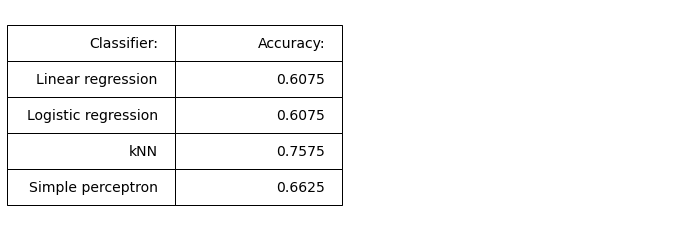

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
tableContent = [["Classifier:", "Accuracy:"],
             ["Linear regression", bestAccLin[1]],
             ["Logistic regression", bestAccLog[1]],
             ["kNN", bestAcckNN[1]],
             ["Simple perceptron", bestAccPer[1]]]
table = ax.table(cellText=tableContent, loc='left')
table.set_fontsize(16)
table.scale(1,3)
ax.axis('off')
plt.show()

The kNN got the best accuracy. This might be because it does a better job at classifying the points where the points of the two classes merges a lot together. It is clear based off of the accuracy of these linear classifiers (and also from the plot from earlier) that the dataset is NOT linearly separable and therefore it is unlikely that any of these classifiers get a high accuracy. It might also be that the training data does not generalize well to the test data, but this is unlikely as the datasets where merged and randomized. 

As the data is only separated into two classes, randomly placing the points into each class would achieve an accuracy of about 0.5. The accuracies of the classifiers are therefore quite poor.

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### *k*NN
One of the classifiers can handle multiple classes without modifications: the *k*-nearest neighbors classifier. Train it on (X_train, t_train), test it on (X_val, t_val) for various values of *k*. Choose the one you find best and report the accuracy.

In [23]:
kRange = range(1, 30, 2)
accuracies = []
index = 0

for k in kRange:
    kNN = PykNNClassifier(k=k)
    kNN.fit(X_train, t_train)
    accuracies.append([k, kNN.accuracy(X_val, t_val)]) 
    print(f"For k = {k}:\nAccuracy: {accuracies[index][1]}\n")
    index +=1

bestAcckNNMulti = max(accuracies, key=lambda x: x[1])

print(f"Best achieved accuracy: {bestAcckNNMulti[1]} with k = {bestAcckNNMulti[0]}")

For k = 1:
Accuracy: 0.6625

For k = 3:
Accuracy: 0.675

For k = 5:
Accuracy: 0.7075

For k = 7:
Accuracy: 0.73

For k = 9:
Accuracy: 0.7425

For k = 11:
Accuracy: 0.7475

For k = 13:
Accuracy: 0.75

For k = 15:
Accuracy: 0.7575

For k = 17:
Accuracy: 0.7525

For k = 19:
Accuracy: 0.755

For k = 21:
Accuracy: 0.76

For k = 23:
Accuracy: 0.7525

For k = 25:
Accuracy: 0.7525

For k = 27:
Accuracy: 0.75

For k = 29:
Accuracy: 0.755

Best achieved accuracy: 0.76 with k = 21


### Logistic regression "one-vs-rest"
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

Extend the logisitc regression classifier to a multi-class classifier. To do this, you must modify the target values from scalars to arrays. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), and report the accuracy.

In [24]:
def LogRegOneVsRest(X_train, t_train, x_val, t_val, eta = 0.1, epochs=10, diff=0.001):
    """
    Run number of training runs equal to number of classes to train for, 
    where each "round" one class will be set to the positive class (1) 
    and the rest to the negative (0)
    
    For three classes:
        First round:
            0 as the positive class, 1 and 2 as the negative
        Second round:
            1 as the positive class, 0 and 2 as the negative
        Third round:
            2 as the positive class, 0 and 1 as the negative
   
    Find the accuracy for each class vs the rest 
    
    Set diff = 1e-6 as that gave the best results during testing of 
    the logistic regression classifier earlier
    
    """
    
    nClasses = set(t_train)
    
    # List to store accuracies
    accuraciesOVR = []
    
    for currentClass in nClasses:
        logRegOVR = NumpyLogReg()
                   
        # Makes new t_lists where all the values in t_train and t_val equal to currentClass
        # are set to 1 and the rest to 0 (a new list where only the currentClass is the positive)
        current_t_train = [1 if currentClass == x in t_train else 0 for x in t_train]    
        current_t_val = [1 if currentClass == x in t_val else 0 for x in t_val]      
        
        # Train the classifier
        logRegOVR.fit(X_train, current_t_train, eta=eta, epochs=epochs, diff=diff) 
        
        # Save the achieved accuracy for the current class    
        acc = logRegOVR.accuracy(X_val, current_t_val)
        accuraciesOVR.append([currentClass, acc])
    return accuraciesOVR

                   
                

In [25]:
# Run the algorithm
accOVR = LogRegOneVsRest(X_train, t_train, X_val, t_val, diff=1e-6)

for i in range(len(accOVR)):
    print(f"For class {accOVR[i][0]} vs Rest:\nAchieved accuracy: {accOVR[i][1]}\n")

print(f"Total accuracy for the logistic regression multi-class classifier\nbased on all three models: {sum(acc[1] for acc in accOVR)/len(accOVR)}")


For class 0 vs Rest:
Achieved accuracy: 0.81

For class 1 vs Rest:
Achieved accuracy: 0.6075

For class 2 vs Rest:
Achieved accuracy: 0.7425

Total accuracy for the logistic regression multi-class classifier
based on all three models: 0.7200000000000001


Discuss the results in a couple of sentences, addressing questions like

- How do the two classfiers compare?
- How do the results on the three-class classification task compare to the results on the binary task?
- What do you think are the reasons for the differences?

With the multi-class kNN I achieved an accuracy of 0,76 (with k = 21 as that gave the best results during earlier testing). The multi-class logistic regression achieved 0,72 for the three models in total. Though the relatively small difference between the two, 4 percent points might be significant as it will prevent some misclassifications (especially if the data is large).

The kNN wwas slightly better, and both performed better than their binary classifier counterpart (0.7575 and 0.6075 for the kNN and the logReg respectively). The kNN multi-classifier is identical to the binary classifier, but run several times. The results gotten from it should be fairly steady regardless of the number of classes. The nature of the data does however play a role; as seen on the plots in task 1, adding a third class might contribute to some of the points in the cluster being classified correctly. The points in class 1 went from being surrounded by class 0-points to having points of both class 0 and class 2 evenly distributed to b0th sides. Had the class 1 points not been present, the classifier probably would have performed a lot better as class 0 and 2 seem to be almost linearly separable. The misclassification probably lies in the the difficulties in separating the class 1 from 0 and 2 respectively. The addition of an extra class seems to have made the individual classes more local to certain areas of the plot, making them a bit easier to generalize. 


## Adding non-linear features

We are returning to the binary classifier and the set (X, t2). As we see, some of the classifiers are not doing too well on the (X, t2) set. It is easy to see from the plot that this data set is not well suited for linear classifiers. There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. This works e.g., for the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). Try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now. Compare to the results for the original features in a 4x2 table.

Explain in a couple of sentences what effect the non-linear features have on the various classifiers. (By the way, some of the classifiers could probably achieve better results if we scaled the data, but we postpone scaling to part 2 of the assignment.)

In [26]:
def addFeatures(X):
   # Find the m dimension of the input matrix 
    m = X.shape[0]
    
    """
    Make matrices with the desired features.

    Extract the features from the input matrix, X (X[:,0]). 
    Apply Lambda function with the respective calculations 
    Reshape to make matrices with size mx1

    """
    
    x1Arr = np.array(list(map(lambda x1: x1**2, X[:,0]))).reshape((m,1))
    x2Arr = np.array(list(map(lambda x2: x2**2, X[:,1]))).reshape((m,1))
    x3Arr = np.array(list(map(lambda x1,x2 : x1*x2, X[:,0], X[:,1]))).reshape((m, 1))
    
    return np.concatenate((x1Arr, x2Arr, x3Arr, X), axis = 1)


In [27]:
new_X_train = addFeatures(X_train)
new_X_val = addFeatures(X_val)

In [28]:
"""

Linear regression with added features
(Same function as used with earlier testing)

"""

linRegFeat = NumpyLinRegClass()
diff = 0.1

resultsLinFeat = []
for i in range(10):
    resultsLinFeat.append(runLin(linRegFeat, new_X_train, t2_train, new_X_val, t2_val, diff=diff)) 
    # Save nested list of diffs and accuracies
    
    diff = diff/10

bestAccLinFeat = max(resultsLinFeat, key=lambda x: x[1])

print(f"Best achieved accuracy: {bestAccLinFeat[1]} with diff = {bestAccLinFeat[0]}")
    


Runs with diff: 0.1: 1
Achieved accuracy: 0.6375

Runs with diff: 0.01: 1
Achieved accuracy: 0.6375

Runs with diff: 0.001: 1
Achieved accuracy: 0.6375

Runs with diff: 0.0001: 1
Achieved accuracy: 0.6375

Runs with diff: 1e-05: 1
Achieved accuracy: 0.6375

Runs with diff: 1.0000000000000002e-06: 1
Achieved accuracy: 0.6375

Runs with diff: 1.0000000000000002e-07: 1
Achieved accuracy: 0.6375

Runs with diff: 1.0000000000000002e-08: 1
Achieved accuracy: 0.6375

Runs with diff: 1.0000000000000003e-09: 1
Achieved accuracy: 0.6375

Runs with diff: 1.0000000000000003e-10: 1
Achieved accuracy: 0.6375

Best achieved accuracy: 0.6375 with diff = 0.1


In [29]:
"""

Logistic regression with added features
(Same function as used with earlier testing)


"""

logRegFeat = NumpyLogReg()
diff = 0.1

results = []
for i in range(10):
    results.append(runLog(logRegFeat, new_X_train, t2_train, new_X_val, t2_val, diff=diff)) 
    # Save nested list of diffs and accuracies
    
    diff = diff/10

bestAccLogFeat = max(results, key=lambda x: x[1])

print(f"Best achieved accuracy: {bestAccLogFeat[1]} with diff = {bestAccLogFeat[0]}")
    


Runs with diff: 0.1: 1
Achieved accuracy: 0.63

Runs with diff: 0.01: 1
Achieved accuracy: 0.63

Runs with diff: 0.001: 1
Achieved accuracy: 0.63

Runs with diff: 0.0001: 1
Achieved accuracy: 0.63

Runs with diff: 1e-05: 1
Achieved accuracy: 0.63

Runs with diff: 1.0000000000000002e-06: 1
Achieved accuracy: 0.63

Runs with diff: 1.0000000000000002e-07: 1
Achieved accuracy: 0.63

Runs with diff: 1.0000000000000002e-08: 1
Achieved accuracy: 0.63

Runs with diff: 1.0000000000000003e-09: 1
Achieved accuracy: 0.63

Runs with diff: 1.0000000000000003e-10: 1
Achieved accuracy: 0.63

Best achieved accuracy: 0.63 with diff = 0.1


In [30]:
"""

kNN with code from earlier

"""


kRange = range(1, 30, 2)
accuracies = []
index = 0

# Makes nested list, accuracies, with k-values on index 0 and accuracies on index 1
for k in kRange:
    kNNFeat = PykNNClassifier(k=k)
    kNNFeat.fit(new_X_train, t2_train)
    accuracies.append([k, kNNFeat.accuracy(new_X_val, t2_val)]) 
    print(f"For k = {k}:\nAccuracy: {accuracies[index][1]}\n")
    index +=1


# Finds the best of the achieved accuracy 
# and makes a list with the k value on index 0 and the accuracy in index 1

bestAcckNNFeat = max(accuracies, key=lambda x: x[1])

print(f"Best achieved accuracy: {bestAcckNNFeat[1]} with k = {bestAcckNNFeat[0]}")

For k = 1:
Accuracy: 0.695

For k = 3:
Accuracy: 0.6925

For k = 5:
Accuracy: 0.7075

For k = 7:
Accuracy: 0.7225

For k = 9:
Accuracy: 0.7275

For k = 11:
Accuracy: 0.7525

For k = 13:
Accuracy: 0.7625

For k = 15:
Accuracy: 0.7525

For k = 17:
Accuracy: 0.75

For k = 19:
Accuracy: 0.745

For k = 21:
Accuracy: 0.7475

For k = 23:
Accuracy: 0.7475

For k = 25:
Accuracy: 0.7525

For k = 27:
Accuracy: 0.76

For k = 29:
Accuracy: 0.7575

Best achieved accuracy: 0.7625 with k = 13


In [31]:
"""

Simple perceptron with code from earlier

"""

accuracies = []
index = 0

for epochs in range(1, 25):
    perceptronFeat = PyPerClassifier()
    perceptronFeat.fit(new_X_train, t2_train, epochs=epochs)
    accuracies.append([epochs, perceptronFeat.accuracy(new_X_val, t2_val)]) 
    print(f"For epochs = {epochs}:\nAccuracy: {accuracies[index][1]}\n")
    index +=1

bestAccPerFeat = max(accuracies, key=lambda x: x[1])
print(f"Best achieved accuracy: {bestAccPerFeat[1]} with epochs = {bestAccPerFeat[0]}")
    

For epochs = 1:
Accuracy: 0.61

For epochs = 2:
Accuracy: 0.6175

For epochs = 3:
Accuracy: 0.615

For epochs = 4:
Accuracy: 0.635

For epochs = 5:
Accuracy: 0.62

For epochs = 6:
Accuracy: 0.645

For epochs = 7:
Accuracy: 0.62

For epochs = 8:
Accuracy: 0.625

For epochs = 9:
Accuracy: 0.63

For epochs = 10:
Accuracy: 0.6375

For epochs = 11:
Accuracy: 0.645

For epochs = 12:
Accuracy: 0.635

For epochs = 13:
Accuracy: 0.6475

For epochs = 14:
Accuracy: 0.63

For epochs = 15:
Accuracy: 0.635

For epochs = 16:
Accuracy: 0.6325

For epochs = 17:
Accuracy: 0.64

For epochs = 18:
Accuracy: 0.6375

For epochs = 19:
Accuracy: 0.64

For epochs = 20:
Accuracy: 0.6375

For epochs = 21:
Accuracy: 0.64

For epochs = 22:
Accuracy: 0.64

For epochs = 23:
Accuracy: 0.6325

For epochs = 24:
Accuracy: 0.64

Best achieved accuracy: 0.6475 with epochs = 13


## Table

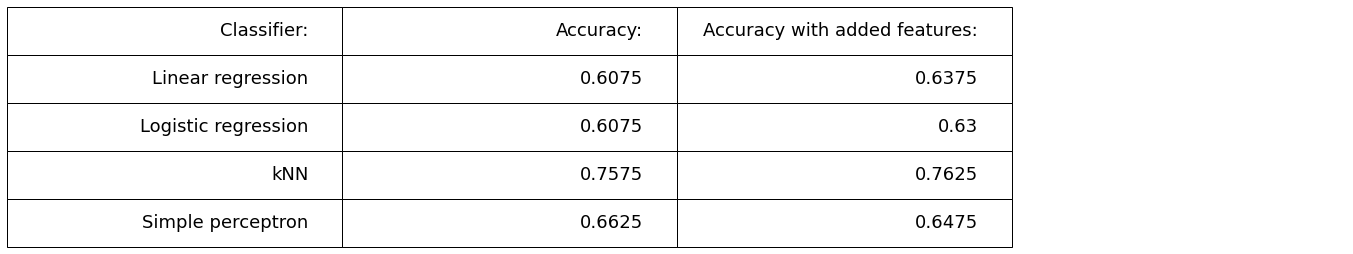

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
tableContent = [["Classifier:", "Accuracy:", "Accuracy with added features:"],
             ["Linear regression", bestAccLin[1], bestAccLinFeat[1]],
             ["Logistic regression", bestAccLog[1], bestAccLogFeat[1]],
             ["kNN", bestAcckNN[1], bestAcckNNFeat[1]],
             ["Simple perceptron", bestAccPer[1], bestAccPerFeat[1]]]
table = ax.table(cellText=tableContent, loc='left')
table.set_fontsize(36)
table.scale(3,4)
ax.axis('off')
plt.show()

All the classifiers performed slightly better with the added features, except the Simple perceptron which performed slightly worse. Seems a bit curious that neither the linear regression or the logistic regression had any differences in accuracy regardless of the diff. It is rather unlikely that both where initialized at a (local/global) minima, but after careful review of the code, I can't seem to find where the bug lies.

Adding the extra features lowers the bias and makes the linear algorithms more suited for more complex problems that hardly generelizes to a simple linear separable problem.
The kNN has a low bias to start with, and therefore the added features don't have a big impact on its accuracy.

# Part II
## Multi-layer neural networks
We will implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do so in two steps. In the first step, we will work concretely with the dataset (X, t). We will initialize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all, you should scale the X.

In [33]:
"""

Max-min-scaling of the instances, X. 

Finds the highest and lowest value for the corresponding features of every instance 
(the max value of the first feature of every instance and so on)

Scale the features according to the maxmin-scaling; 
    Find the max and min of each dimension i = 1, ... n
    For every feature xj,i: xj,i = (xj,i - minj)/(maxj-minj)

This squashes all the features to a number between 0 and 1    


"""

def maxMinScaling(X):
    m = X.shape[0] # Number of instances
    n = X.shape[1] # Number of features per instance
    scaledX = np.zeros((m, n))
    for i in range(n): # For every column in the matrix X
        maxVal = max(X[:,i]) # Finds max value of the features on index i
        minVal = min(X[:,i])
        dif = maxVal-minVal
        scaledX[:,i] = (np.array(list(map(lambda x: float((x-minVal)/dif), X[:,i]))).reshape(m,))
    
    return scaledX


In [34]:
scaled_X_train = maxMinScaling(X_train)

## Step1: One round of training

### Initialization
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [35]:
eta = 0.01 # Learning rate
dim_hidden = 6 # number of nodes in the hidden layer, tuneable

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *t_train*. Beware that *t_train* must be given the form of *P x dim_out* at some point, cf. the "one-vs-all" exercise above.

In [36]:
dim_in =  X_train.shape[1] # Number of features
dim_out = len(set(t_train)) # Number of different labels and therefore the number of output nodes

We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make the weight matrices and initialize them to small random numbers. Make sure that you take the bias terms into consideration and get the correct dimensions.

In [37]:
"""
Shape of weightHid (the hidden weights):
    Rows equal the number of attributes for the observations
    Columns equal the number of hidden nodes
    => X_train.shape[1] x dim_hidden
    
    
Shape of weightOut (the output weights):
    Rows equal the number of hidden layer nodes
    Columns equal the number of output layer nodes
    => dim_hidden x dim_out
        
    
Shape of biasHid (bias to the hidden nodes):
    Each node in the hidden layer has its own bias 
    Dimension is 1 x dim_hidden
    
Shape of biasOut (bias to the output nodes)
    Each node in the output layer has its own bias
    Dimension is 1 x dim_out
    
    
Shape of the output values, Y, after running the forward-function on the first layer:
    The rows should match the number of training instances, X_train.shape[0]
    The columns should match the number of nodes in the hidden layer
    
Shape of Y after application on the last layer:
    The rows should match the rows of the hidden layer matrix, X_train.shape[0]
    The columns should match the number of labels/classes we wish to classify (dim_out),
    which also equals the number of output nodes
    
    
"""
# Initialize the weights
weightsHid = np.random.rand(dim_in, dim_hidden)
weightsOut = np.random.rand(dim_hidden, dim_out)

# Initialize bias to -1
biasHid = -np.ones(dim_hidden)
biasOut = -np.ones(dim_out)

### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [38]:
def forward(X, weights, bias):
    
    # Sum of inputs to each nex layer node, from the connections leading into it times its weight
    Z = (X @ weights) + bias
    
    # The activation function; Z squashed into a sigmoid. 
    # Should produce a number between 0 and 1
    Y = logistic(Z)
    
    return Y

In [39]:
hidden_activations = forward(scaled_X_train, weightsHid, biasHid)

In [40]:
output_activations = forward(hidden_activations, weightsOut, biasOut)

In [41]:
print(f"Hidden layer activation values:\n{hidden_activations}")
print(f"\nHidden activation matrix shape:\n{hidden_activations.shape}\n")

print(f"Output layer activation values:\n{output_activations}\n")
print(f"Output activation matrix shape:\n{output_activations.shape}")

Hidden layer activation values:
[[0.49704833 0.36396752 0.37676747 0.41502332 0.48639416 0.44555894]
 [0.55168068 0.37901116 0.40841169 0.45912758 0.5374943  0.48543661]
 [0.42519062 0.32480179 0.34993488 0.37951394 0.41621135 0.38585375]
 ...
 [0.37678962 0.31773537 0.31876212 0.33547467 0.3722572  0.35391512]
 [0.53369786 0.37473612 0.39735817 0.44368073 0.52075787 0.47251017]
 [0.465853   0.34664568 0.36519887 0.39974458 0.45585392 0.41942955]]

Hidden activation matrix shape:
(800, 6)

Output layer activation values:
[[0.66533261 0.58903682 0.47775996]
 [0.69990991 0.62076473 0.49814683]
 [0.62058956 0.55152018 0.4549639 ]
 ...
 [0.58649681 0.52155765 0.43657451]
 [0.68858816 0.61018111 0.49124789]
 [0.64619032 0.5728402  0.46783852]]

Output activation matrix shape:
(800, 3)


All the returned values seems to be between 0 and 1 (based off of what is visible when printing the matrix), which is the desired range when using the logistic function. 

The shape matches the desired specifications stated above.

### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sums of squared errors. (This amounts to the same as using the mean square error).

In [42]:
# Convert the vector of target values (t_train) to a matrix with one-hot-encodings

def toOneHot(labelList):
    nClasses = len(set(labelList))  
    oneHotArray = []
    
    for label in labelList:
        # Make list with number of elements equal to number of classes, 
        # where the integer class name (0, 1, 2...) is also the index where there should be a 1
        convert = [1 if x == label else 0 for x in range(nClasses)] 
        oneHotArray.append(convert)
    return np.array(oneHotArray) #Convert to numpy array for compatibility


new_t_train = toOneHot(t_train)

In [43]:
"""
The delta for the last layer is the error (calculated value - true value) times the 
derivative of the activation function, which is (calculated values*(1 - calculated values))

"""

deltaOut = (output_activations - new_t_train)*(output_activations * (1 - output_activations))

Calculate the delta terms in the hidden layer.

In [44]:
"""

The delta term in the hidden layers is 
delta(k) @ output_weights.T * a*(1-a), 
    where a is the matrix with hidden activations 
    and delta(k) the delta value from the last layer.
    weights transposed to achieve correct dimensions
    
"""
deltaHidden =  hidden_activations*(1 - hidden_activations)*(deltaOut @ weightsOut.T)

Update the weights.
Check that they have changed.
As the weights depend on the random initialization, there is no unique correct solution at this point. But you should be able to see that the weights have been updated.

In [45]:
"""
Updating the weights, where eta is the learning rate
    weightsHid -= eta*delta(hidden) * X
    weightsOut -= eta*delta(k)*a
    
    Have to transpose the hidden_activations and 
    swap places to get the correct dimensions

    
"""

newBiasOut = biasOut - (eta * np.sum(deltaOut, axis=0))
newBiasHid = biasHid - (eta * np.sum(deltaHidden, axis=0))
newWeightsOut = weightsOut - (eta * (hidden_activations.T @ deltaOut))
newWeightsHid = weightsHid - (eta * (scaled_X_train.T @ deltaHidden))

#  Check if update gave new values:

print(f"Old weights from input to hidden layer:\n{weightsHid}\n")
print(f"New weights from input to hidden layer:\n{newWeightsHid}\n")
print(f"Old bias from input to hidden layer:\n{biasHid}\n")
print(f"New bias from input to hidden layer:\n{newBiasHid}\n")

print(f"Old weights from hidden to output layer:\n{weightsOut}\n")
print(f"New weights from hidden to output layer:\n{newWeightsOut}")
print(f"Old bias from hidden to output layer:\n{biasOut}\n")
print(f"New bias from hidden to output layer:\n{newBiasOut}\n")


Old weights from input to hidden layer:
[[0.9488982  0.66540906 0.31515228 0.3890839  0.94468093 0.84373784]
 [0.90408914 0.07980154 0.67209353 0.92581604 0.81569504 0.58917309]]

New weights from input to hidden layer:
[[0.87373659 0.60170898 0.20286819 0.25492    0.83503614 0.78379157]
 [0.81891197 0.00955161 0.54645706 0.78165076 0.69182743 0.52450225]]

Old bias from input to hidden layer:
[-1. -1. -1. -1. -1. -1.]

New bias from input to hidden layer:
[-1.13113866 -1.12405315 -1.20559656 -1.26430192 -1.20120506 -1.1066297 ]

Old weights from hidden to output layer:
[[0.64546568 0.45875375 0.01575814]
 [0.41750586 0.05647732 0.4972694 ]
 [0.8537905  0.56051056 0.36530285]
 [0.71289467 0.945444   0.94436043]
 [0.83254968 0.26570265 0.37229105]
 [0.43062318 0.84973429 0.02583857]]

New weights from hidden to output layer:
[[ 0.25582915  0.39723113 -0.19727977]
 [ 0.15652655  0.0095991   0.33664452]
 [ 0.55853292  0.51184527  0.19375084]
 [ 0.37925383  0.89246908  0.75746584]
 [ 0.454

The old and new weights are different, the updates presumably work as intended
(given that the earlier code gives correct results of course)

##  Step 2: A Multi-layer neural network classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.

In [46]:
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.001, dim_hidden = 6):
        """Initialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden

    def fit(self, X_train, t_train, epochs = 100):
        """Initialize the weights. Train *epochs* many epochs."""
        
        dim_in = X_train.shape[1]
        dim_out = len(set(t_train))
        
        # Initialize the weights. Scale down as Marsland does
        self.weightsHid = np.random.rand(dim_in, self.dim_hidden)*(1/np.sqrt(dim_in))
        self.weightsOut = np.random.rand(self.dim_hidden, dim_out)*(1/np.sqrt(dim_in))
        
        # Initialize bias to -1
        self.biasHid = -np.ones((1, self.dim_hidden))*(1/np.sqrt(dim_in))
        self.biasOut = -np.ones((1, dim_out))*(1/np.sqrt(dim_in))
        
        # Make the One-Hot encoding of the t-values. 
        self.oneHot_t_train = toOneHot(t_train)
        
        for e in range(epochs):
            # FORWARD
            hidden_activations, output_activations = self.forward(X_train)
            
            # BACKWARDS
            
            # To update weights, find the error (deltas) using MSE for hidden and output layer
            deltaOut = (self.oneHot_t_train - output_activations)*(output_activations*(1 - output_activations))
            deltaHidden = (deltaOut @ self.weightsOut.T) * hidden_activations*(1 - hidden_activations)
            
            # Update weights and biases using the deltas
            self.biasOut += (eta * np.sum(deltaOut, axis=0))
            self.biasHid += (eta * np.sum(deltaHidden, axis=0))
            self.weightsOut += eta * (hidden_activations.T @ deltaOut)
            self.weightsHid += eta * (X_train.T @ deltaHidden)
            
            # self.backward(X_train, self.oneHot_t_train, hidden_activations, output_activations)
            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        
        hiddenAct = logistic((X @ self.weightsHid) + self.biasHid)
        outputAct = logistic((hiddenAct @ self.weightsOut) + self.biasOut)
        
        return hiddenAct, outputAct

    """
    
    Tried writing the backwards steps as its own function, but after debugging and testing
    for a long time, I can't figure out why it won't update the weights as it should
    
    def backward(self, X_train, t_train, hidden_activation, output_activation):
   # To update weights, find the error (deltas) using MSE for hidden and output layer
    deltaOut = (t_train - output_activations)*(output_activations*(1 - output_activations))
    deltaHidden = (deltaOut @ self.weightsOut.T) * hidden_activations*(1 - hidden_activations)


    # Update weights using the deltas     
    self.biasOut += (self.eta * np.sum(deltaOut, axis=0,keepdims=True))
    self.biasHid += (self.eta * np.sum(deltaHidden, axis=0, keepdims=True))
    self.weightsHid += self.eta * (X_train.T @ deltaHidden)
    self.weightsOut += self.eta * (hidden_activations.T @ deltaOut)

    
    """

    def accuracy(self, X_test, t_test):
        """Calculate the accuracy of the classifier for the pair (X_test, t_test)
        Return the accuracy"""
        
        """
        The accuracy is defined as (tp+np)/(tp+fp+tn+fn), 
        => (tp+tn)/all instances
        
        The output from the last layer is the result of the logistic-function,
        returning three numbers for each row between 0 and 1. The algorithm should then choose
        the one of the three values that is highest as the predicted value for the instance
        ([0.3, 0.6, 0.5] should be predicted to be class [0,1,0] = class 1)

        """
        
        # Convert the t_train to One-Hot:
        oneHot_t_train = toOneHot(t_test)
        
        # Get the predictions for the solution. Equal to the output activations.
        #(forward() also returns the hidden activations, but these will not be used here)
        dontCare, predictions = self.forward(X_test)
            
        oneHotPred = np.array([[1 if innerIndex == np.argmax(row) else 0 for innerIndex in range(len(row))] for row in predictions])
    
        """
        
        The list comprehension above iterates through the rows in predictions (a row represents one prediction, 
        represented in one-hot format), sets the highest value in the row to 1, the rest to 0;
            argmax(row) returns the index of the highest value in every row in prediction
            Sets the value on this index in oneHotPred to 1 and the other values in the same row to 0

        """
    
        # Finding the true positives by comparing to the t_train
        n = oneHotPred.shape[0]
        tp = 0
        
        #Compare the predicted value to the true label
        for i, j in zip(oneHotPred, oneHot_t_train):
            if np.all(i == j):
                tp += 1   
                
        return tp/n

    def predictions(self, X):
        hidden, predictions = self.forward(X)
        predictions = [np.argmax(row) for row in predictions]
        
        return predictions


Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Adjust hyperparameters or number of epochs if you are not content with the result.

In [47]:
scaled_X_val = maxMinScaling(X_val)
scaled_X_train = maxMinScaling(X_train)

eta = 0.1
epochs = 3000
mnn = MNNClassifier(eta)
mnn.fit(scaled_X_train, t_train, epochs)

print(mnn.accuracy(scaled_X_val, t_val))

0.69


I got good results with eta = 0.01 and epochs = 2500. Achieved an accuracy of 0.6875 at best when testing on X_val and t_val

69 eta 0.1, epochs 3000

## Make a neural network classifier for (X, t2)
Let us see whether a multilayer neural network can learn a non-linear classifier.
Train it on (X_train, t2_train) and test it on (X_val, t2_val).
Tune the hyper-parameters for the best result.

In [48]:
eta = 0.01
epochs = 3000

mnnBin = MNNClassifier(eta)
mnnBin.fit(scaled_X_train, t2_train, epochs)

print(mnnBin.accuracy(scaled_X_val, t2_val))


0.68


Achieved a maximum of 0,69 with eta = 0.01 and epochs = 3000.

Slightly less than expected, isnt that much better than many of the other linear classifiers

# Part III: Final testing
Take the best classifiers that you found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall. Answer in 2-3 sentences: How do the accuracies compare to the results on the validation sets?

The best classifier I got was the kNN for both the non-binary and binary set. I suspect
the multi-layer neural network should have performed better than it on at least one of the problems, so 
I will choose these two classifiers for final testing

Got k = 21 as best k for both training sets earlier, so will use that here as well for the kNN

In [49]:
"""

Code for confusion matrix fetched from week05 solutions


"""

def cf_matrix(predicted, gold):
    table = np.zeros((2,2))
    for p,g in zip(predicted, gold):
        table[int(p), g] +=1
    print(28*" "+"gold")
    print("{:20}|{:>9}|{:>9}|".format(" ","neg", "pos"))
    print(10*" "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","neg",table[0,0], table[0,1]))
    print("predicted "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","pos",table[1,0], table[1,1]))
    print(10*" "+30*"-")
    
    tp = table[1,1]
    tn = table[0,0]
    fp = table[1,0]
    fn = table[0,1]
   
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    
    return accuracy, precision, recall
    
def cf_matrix_3(predicted, gold):
    table = np.zeros((3,3))
    for p,g in zip(predicted, gold):
        table[int(p), int(g)] +=1
    print(28*" "+"gold")
    print("{:20}|{:>9}|{:>9}|{:>9}|".format(" ","class0", "class1", "class 2"))
    print(10*" "+45*"-")
    print("{:10}{:10}|{:9}|{:9}|{:9}|".format(" ","class0",table[0,0], table[0,1], table[0,2]))
    print("predicted "+45*"-")
    print("{:10}{:10}|{:9}|{:9}|{:9}|".format(" ","class1",table[1,0], table[1,1], table[1,2]))
    print(10*" "+45*"-")
    print("{:10}{:10}|{:9}|{:9}|{:9}|".format(" ","class2",table[2,0], table[2,1], table[2,2]))
    print(10*" "+45*"-")
    
    prec1 = table[0,0]/(table[0,0]+table[0,1]+table[0,2])
    prec2 = table[1,1]/(table[1,0]+table[1,1]+table[1,2])
    prec3 = table[2,2]/(table[2,0]+table[2,1]+table[2,2])
    rec1 = table[0,0]/(table[0,0]+table[1,0]+table[2,0])
    rec2 = table[1,1]/(table[0,1]+table[1,1]+table[2,1])
    rec3 = table[2,2]/(table[0,2]+table[1,2]+table[2,2])
    accuracy = (table[0,0]+table[1,1]+table[2,2])/len(predicted)
    
    return prec1, prec2, prec3, rec1, rec2, rec3, accuracy

In [50]:
"""

For the binary kNN

"""
knnBin = PykNNClassifier(k=21)
knnBin.fit(X_train, t2_train)
predKnnBin = [knnBin.predict(x) for x in X_test]

In [51]:
print("\n         Confusion matrix kNN, t2_test\n")

accKnnBin, precKnnBin, recKnnBin = cf_matrix(predKnnBin, t2_test)
print(f"\nAccuracy: {accKnnBin}\nPrecision: {precKnnBin}\nRecall: {recKnnBin}\n")


         Confusion matrix kNN, t2_test

                            gold
                    |      neg|      pos|
          ------------------------------
          neg       |    140.0|     35.0|
predicted ------------------------------
          pos       |     65.0|    160.0|
          ------------------------------

Accuracy: 0.75
Precision: 0.7111111111111111
Recall: 0.8205128205128205



In [52]:
"""

mnnBin is already trained to the correct training sets

"""
scaled_X_test = maxMinScaling(X_test)

mnnBinPred = mnnBin.predictions(scaled_X_test)

In [53]:
print("\n         Confusion matrix MNN, t2_test\n")

accMnnBin, precMnnBin, recMnnBin = cf_matrix(mnnBinPred, t2_test)
print(f"\nAccuracy: {accMnnBin}\nPrecision: {precMnnBin}\nRecall: {recMnnBin}\n")


         Confusion matrix MNN, t2_test

                            gold
                    |      neg|      pos|
          ------------------------------
          neg       |    156.0|     46.0|
predicted ------------------------------
          pos       |     49.0|    149.0|
          ------------------------------

Accuracy: 0.7625
Precision: 0.7525252525252525
Recall: 0.764102564102564



In [54]:
knnThree = PykNNClassifier(k=21)
knnThree.fit(X_train, t_train)
predKnnThree = [knnBin.predict(x) for x in X_test]

In [55]:
print("\n           Confusion matrix kNN, t_test\n")
prec0, prec1, prec2, rec0, rec1, rec2, accuracy = cf_matrix_3(predKnnThree, t_test)

print(f"Total accuracy:\n{accuracy}")
print(f"\nFor class 0:\nPrecision: {prec0}\nRecall: {rec0}\n")
print(f"\nFor class 1:\nPrecision: {prec1}\nRecall: {rec1}\n")
print(f"\nFor class 2:\nPrecision: {prec2}\nRecall: {rec2}\n")


           Confusion matrix kNN, t_test

                            gold
                    |   class0|   class1|  class 2|
          ---------------------------------------------
          class0    |     70.0|     35.0|     70.0|
predicted ---------------------------------------------
          class1    |     22.0|    160.0|     43.0|
          ---------------------------------------------
          class2    |      0.0|      0.0|      0.0|
          ---------------------------------------------
Total accuracy:
0.575

For class 0:
Precision: 0.4
Recall: 0.7608695652173914


For class 1:
Precision: 0.7111111111111111
Recall: 0.8205128205128205


For class 2:
Precision: nan
Recall: 0.0



C:\Users\frida\anaconda3\envs\in3050\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


In [56]:
"""

Use the mnnBin from above, as it is already trained on the correct set.

Add a function in the classifier, predictions, which will return its predictions

"""

accMnnBin = mnnBin.accuracy(scaled_X_test, t2_test)
predMnnBin = mnnBin.predictions(scaled_X_test)


eta = 0.01
epochs = 3000
mnnThree = MNNClassifier(eta)
mnnThree.fit(scaled_X_train, t_train, epochs)

accMnnThree = mnnThree.accuracy(scaled_X_test, t_test)
predMnnThree = mnnThree.predictions(scaled_X_test)

In [57]:
print("\n           Confusion matrix MNN, t_test\n")

prec0, prec1, prec2, rec0, rec1, rec2, accuracy = cf_matrix_3(predMnnThree, t_test)

print(f"Total accuracy:\n{accuracy}")
print(f"\nFor class 0:\nPrecision: {prec0}\nRecall: {rec0}\n")
print(f"\nFor class 1:\nPrecision: {prec1}\nRecall: {rec1}\n")
print(f"\nFor class 2:\nPrecision: {prec2}\nRecall: {rec2}\n")


           Confusion matrix MNN, t_test

                            gold
                    |   class0|   class1|  class 2|
          ---------------------------------------------
          class0    |     71.0|      9.0|      0.0|
predicted ---------------------------------------------
          class1    |     21.0|    156.0|     33.0|
          ---------------------------------------------
          class2    |      0.0|     30.0|     80.0|
          ---------------------------------------------
Total accuracy:
0.7675

For class 0:
Precision: 0.8875
Recall: 0.7717391304347826


For class 1:
Precision: 0.7428571428571429
Recall: 0.8


For class 2:
Precision: 0.7272727272727273
Recall: 0.7079646017699115



The multi-layer network performed better now than during testing on the validation set. The kNN performed approximately the same as earlier. Also, they performed about the same on both the training and test sets.